# Parte 3 Estudio de temperatura

En este ultimo apartado del proyecto, se estudia la temperatura en los 4 últimos años (incluyendo este) en Venecia, ya que el aumento de temperatura (el cambio climático) es la causa del aumento del nivel del mar.

Gracias a la tecnología de Sentinel-3 SLSTR se puede obtener información de la radiancia en el nivel infrarrojo térmico, permitiéndonos crear un mapa de temperaturas.
La radiancia está directamente relacionada con la temperatura, por la ley de Stefan-Boltzmann:
$$R = \sigma T^4$$

Lo que quiere decir que un aumento de radiancia, supone una aumento de la temperatura.

Con el siguiente código se puede acceder a las imágenes en infrarrojo térmico de Venecia, se usará la banda S8 (con longitud de onda de 10,8 µm), y crear así un mapa de temperaturas.

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import getpass
from pathlib import Path
from typing import Any, Optional, Tuple
import cv2 as cv
import math

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)
config = SHConfig('Teledeteccion')

In [31]:
aoi_coords_wgs84 = aoi_coords_wgs84 = [12.27, 45.395, 12.39, 45.485]  
                                                            
resolution = 10                                            
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels") # Para el ejemplo, de 1100x1100 px

Image shape at 10 m resolution: (972, 969) pixels


In [32]:
# Java script asjustado para la banda, tiened que devolver la imagen en FLOAT32 para que vaya bien
evalscript_termico = """
    function setup() {
        return {
            input: [{
                bands: ["S7", "S8", "S9"]
            }],
            output: {
                bands: 3, sampleType: "FLOAT32" 
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.S7, sample.S8, sample.S9];
    }
"""

In [33]:
def devuelve_imagen_s3(fechas):
    request_s3_termico = SentinelHubRequest(
    evalscript=evalscript_termico,
    input_data=[
        SentinelHubRequest.input_data(
            # se cambia el nombre del DataCollection, se escoge el satélite SLSTR de sentinel
            data_collection=DataCollection.SENTINEL3_SLSTR.define_from(
                name="s3slstr", # se cambia este 
                service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=fechas,
            # No se puede indicar que se quiere la menor covertura de nubes posible
            other_args={"dataFilter":  {"maxCloudCoverage": 10}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,)
    termical_imgs = request_s3_termico.get_data()
    res1 = termical_imgs[0]
    return res1

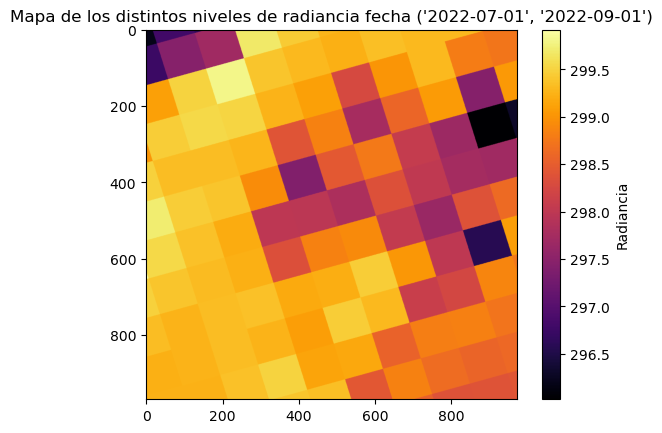

valor maximo de radiancia:  299.92
valor mínimo de radiancia:  293.82
valor medio de radiancia:  297.3038


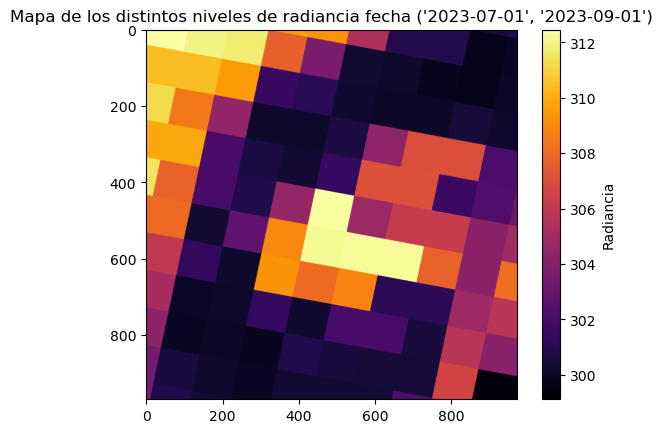

valor maximo de radiancia:  312.46
valor mínimo de radiancia:  294.93
valor medio de radiancia:  300.02924


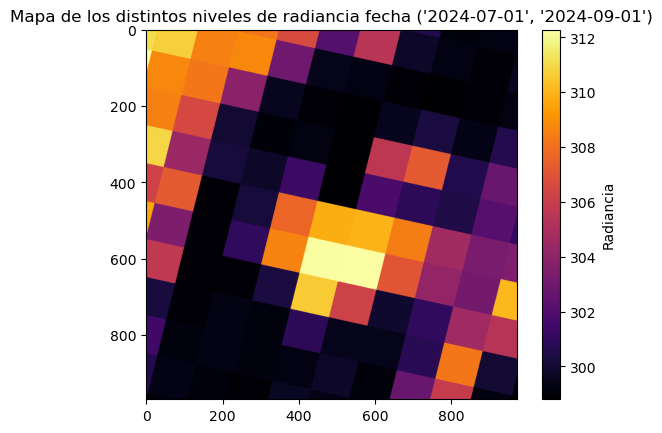

valor maximo de radiancia:  312.28
valor mínimo de radiancia:  294.94
valor medio de radiancia:  299.1647


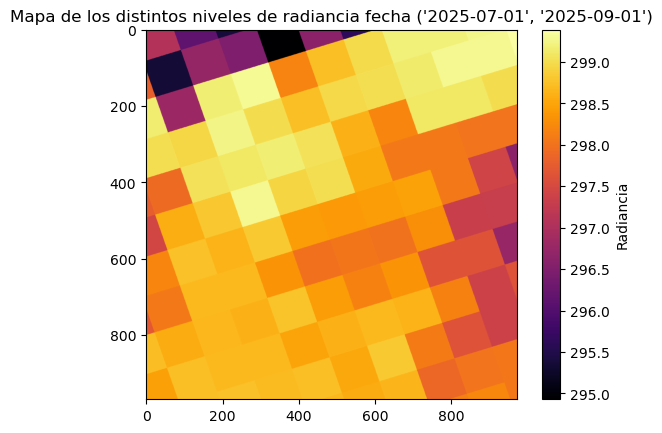

valor maximo de radiancia:  299.39
valor mínimo de radiancia:  293.25
valor medio de radiancia:  297.01407


In [34]:
fechas=[("2022-07-01", "2022-09-01"), ("2023-07-01", "2023-09-01"),("2024-07-01", "2024-09-01"),("2025-07-01", "2025-09-01")]
ls_valor_max = []
ls_valor_min = []
ls_valor_med = []
ls_años = []
for f in fechas:
    init,_ = f
    ls_años.append(init.split('-')[0])
    img = devuelve_imagen_s3(f)
    #El valor maximo de radiancia
    valor_max = np.max(img)
    ls_valor_max.append(valor_max)
    #El valor minimo de radiancia
    valor_min = np.min(img)
    ls_valor_min.append(valor_min)
    #El valor medio de radiancia
    valor_med = np.mean(img)
    ls_valor_med.append(valor_med)
    # Para ver la banda S8, con un mapa de colores en infierno (calor)
    plt.imshow(img[:,:,0],cmap= "inferno")
    plt.colorbar(label="Radiancia")
    plt.title(f"Mapa de los distintos niveles de radiancia fecha {f}")
    plt.show()
    print("valor maximo de radiancia: ", valor_max)
    print("valor mínimo de radiancia: ", valor_min)
    print("valor medio de radiancia: ", valor_med)

Para valores más claros de pixel, mayor radiancia en esa zona, más calor.
Los pixeles más oscuros indican una menor radiancia, menor temperatura.

### Conclusiones
Gracias al mapa generado de temperaturas, se puede estudiar también como ha evolucionado la radiancia máxima, mínima y media durante los últimos 4 años.

**Función de radiancia Máxima**

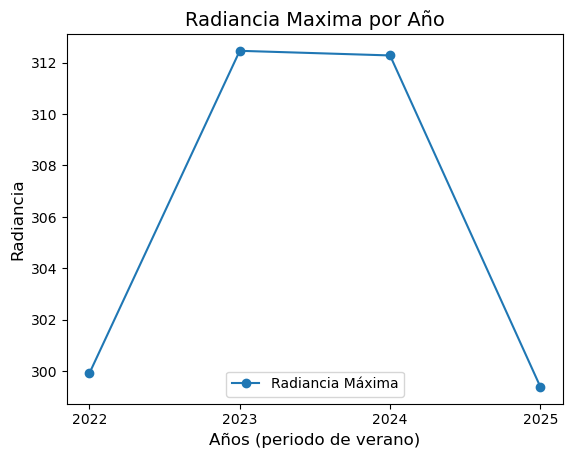

In [35]:
plt.plot(ls_años,ls_valor_max,marker='o',label='Radiancia Máxima')
plt.title("Radiancia Maxima por Año", fontsize=14)
plt.xlabel("Años (periodo de verano)", fontsize=12)
plt.ylabel("Radiancia", fontsize=12)
plt.legend()
plt.show()

**Función de radiancia Mínima**

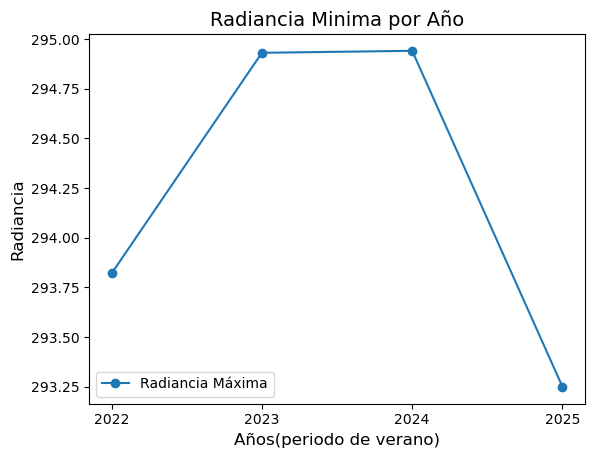

In [36]:
plt.plot(ls_años,ls_valor_min,marker='o',label='Radiancia Máxima')
plt.title("Radiancia Minima por Año", fontsize=14)
plt.xlabel("Años(periodo de verano)", fontsize=12)
plt.ylabel("Radiancia", fontsize=12)
plt.legend()
plt.show()

**Función de radiancia Media**

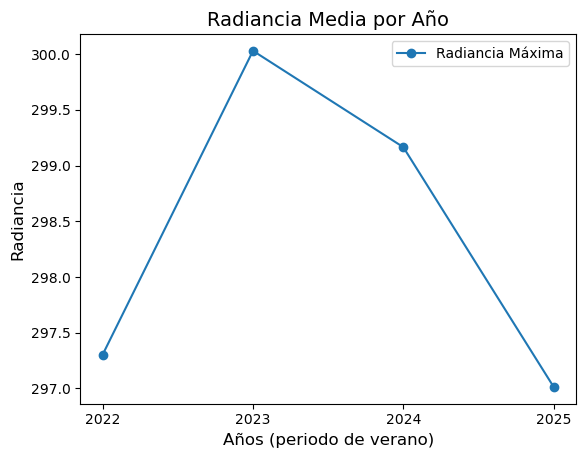

In [38]:
plt.plot(ls_años,ls_valor_med,marker='o',label='Radiancia Máxima')
plt.title("Radiancia Media por Año", fontsize=14)
plt.xlabel("Años (periodo de verano)", fontsize=12)
plt.ylabel("Radiancia", fontsize=12)
plt.legend()
plt.show()

- Donde se da la mayor radiancia máxima es en 2024
- Durante 2023 y 2024 se da los picos de radiancia 

## Bibliografía

- NDTI: https://innoter.com/en/articles/types-of-water-indixes-and-their-applications/#:~:text=other%20environmental%20aspects.-,Normalized%20Difference%20Thermal%20Index%20(NDTI),relatively%20clean%20and%20not%20turbid. 
- NDWI: https://eos.com/es/make-an-analysis/ndwi/ 
- Stefan–Boltzmann law: https://en.wikipedia.org/wiki/Stefan%E2%80%93Boltzmann_law#:~:text=For%20an%20ideal%20absorber/emitter,the%20black%20body's%20temperature%2C%20T:&text=%CF%83%20=%205.670374419..,%E2%88%922%E2%8B%85K%E2%88%924. 
Sentinel-3: https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/slstr/ 